In [ ]:
!apt-get update 
!apt-get install g++ openjdk-8-jdk 
!pip install konlpy JPype1-py3 
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)



In [2]:
import tensorflow as tf

In [3]:
import pandas as pd


train_data = pd.read_table('/content/drive/MyDrive/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[4])
print(word_to_index)

.
{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, '<UNUSED>': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못':

In [6]:

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]


def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외


def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

 
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [9]:
x_val = X_train[:20000]
y_val = y_train[:20000]

partial_x_train = X_train[20000:]
partial_y_train = y_train[20000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


In [10]:
vocab_size = len(index_to_word)
word_vector_dim = 300

In [11]:
#RNN Model
 
rnn_model = tf.keras.Sequential(name='RNN')
rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(tf.keras.layers.LSTM(8))   
rnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

rnn_model.summary()

Model: "RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         3000000   
                                                                 
 lstm (LSTM)                 (None, 8)                 9888      
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


In [12]:
# 1-D CNN Model

cnn_model = tf.keras.Sequential(name='CNN')
cnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling1D(5))
cnn_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
cnn_model.add(tf.keras.layers.GlobalMaxPooling1D())
cnn_model.add(tf.keras.layers.Dense(8, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

cnn_model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         3000000   
                                                                 
 conv1d (Conv1D)             (None, None, 16)          33616     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                 136     

In [13]:
# GlobalMaxPooling1D Model

gmp_model = tf.keras.Sequential(name='GMP')
gmp_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
gmp_model.add(tf.keras.layers.GlobalMaxPooling1D())
gmp_model.add(tf.keras.layers.Dense(8, activation='relu'))
gmp_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

gmp_model.summary()

Model: "GMP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         3000000   
                                                                 
 global_max_pooling1d_1 (Glo  (None, 300)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 2408      
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,002,417
Trainable params: 3,002,417
Non-trainable params: 0
_________________________________________________________________


In [17]:
models = [rnn_model.name,cnn_model.name,gmp_model.name]

In [19]:
model_results = {}
history_dict = {}
for model_name in models :
  if model_name == 'RNN' : model = rnn_model
  elif model_name == 'CNN' : model = cnn_model
  else : model = gmp_model


  model.compile(optimizer='adam',loss='binary_crossentropy',
              metrics=['accuracy'])

  epochs = 10
  print('-'*10 + model_name +'-'*10)
  history = model.fit(partial_x_train,partial_y_train,epochs=epochs,
                    batch_size=512,validation_data=(x_val,y_val),verbose=1)
  print('-'*10 + model_name + 'results'+'-'*10)  
  results = model.evaluate(X_test,y_test,verbose=2)
  model_results[model_name] = results
  history_dict[model_name] = history.history

----------RNN----------
Epoch 1/10
247/247 [==============================] - 39s 151ms/step - loss: 0.0843 - accuracy: 0.9717 - val_loss: 0.6336 - val_accuracy: 0.8357
Epoch 2/10
247/247 [==============================] - 36s 147ms/step - loss: 0.0723 - accuracy: 0.9762 - val_loss: 0.6645 - val_accuracy: 0.8378
Epoch 3/10
247/247 [==============================] - 36s 146ms/step - loss: 0.0687 - accuracy: 0.9775 - val_loss: 0.6849 - val_accuracy: 0.8352
Epoch 4/10
247/247 [==============================] - 36s 145ms/step - loss: 0.0646 - accuracy: 0.9784 - val_loss: 0.7139 - val_accuracy: 0.8324
Epoch 5/10
247/247 [==============================] - 36s 146ms/step - loss: 0.0603 - accuracy: 0.9801 - val_loss: 0.7436 - val_accuracy: 0.8301
Epoch 6/10
247/247 [==============================] - 36s 144ms/step - loss: 0.0579 - accuracy: 0.9806 - val_loss: 0.7673 - val_accuracy: 0.8307
Epoch 7/10
247/247 [==============================] - 35s 143ms/step - loss: 0.0563 - accuracy: 0.9816 - v

In [20]:
model_results

{'CNN': [0.8233165144920349, 0.8306446671485901],
 'GMP': [0.5933478474617004, 0.8402262330055237],
 'RNN': [0.8247413635253906, 0.8267591595649719]}

In [21]:
history_dict

{'CNN': {'accuracy': [0.7800874710083008,
   0.8727393746376038,
   0.9019511342048645,
   0.9337306618690491,
   0.9596614241600037,
   0.9737204909324646,
   0.9815266728401184,
   0.9872327446937561,
   0.9893090724945068,
   0.9906880259513855],
  'loss': [0.4703264534473419,
   0.3039209246635437,
   0.24475157260894775,
   0.17957118153572083,
   0.11936929821968079,
   0.08125623315572739,
   0.058248694986104965,
   0.04349616542458534,
   0.03585123270750046,
   0.031125547364354134],
  'val_accuracy': [0.8500000238418579,
   0.8619499802589417,
   0.8598499894142151,
   0.8524500131607056,
   0.8460000157356262,
   0.8416000008583069,
   0.8413500189781189,
   0.8373000025749207,
   0.8399999737739563,
   0.8330000042915344],
  'val_loss': [0.3434886336326599,
   0.32486793398857117,
   0.3370230793952942,
   0.37720656394958496,
   0.45561274886131287,
   0.5273007750511169,
   0.5857496857643127,
   0.6684983968734741,
   0.7102551460266113,
   0.8042342066764832]},
 'GMP':

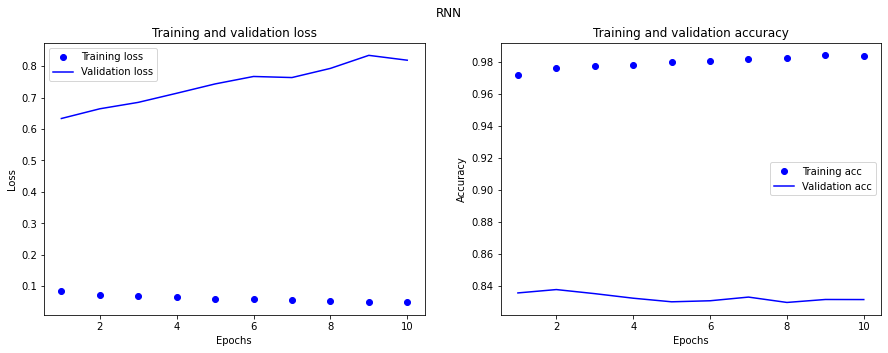

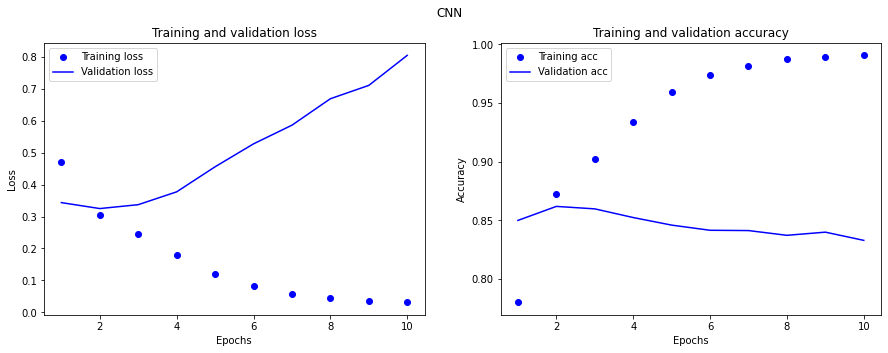

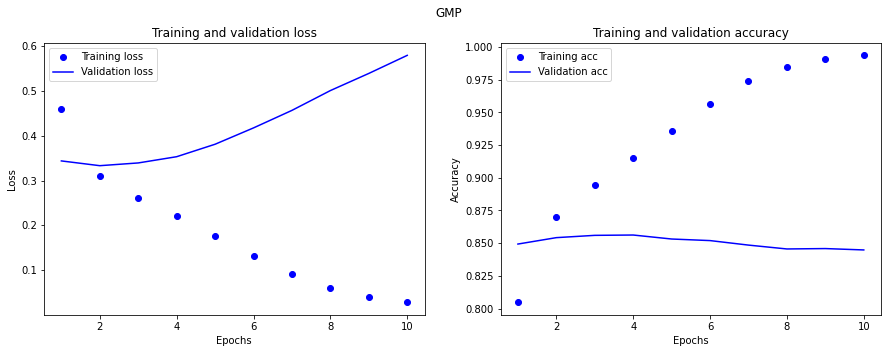

In [46]:
import matplotlib.pyplot as plt

keys = list(history_dict.keys())


for i in range(3):
  fig = plt.figure(i,figsize=(15,5))
  fig.suptitle(keys[i])

  acc = history_dict[keys[i]]['accuracy']
  val_acc = history_dict[keys[i]]['val_accuracy']
  loss = history_dict[keys[i]]['loss']
  val_loss = history_dict[keys[i]]['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.subplot(1,2,1)
  plt.plot(epochs,loss,'bo',label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()



In [23]:
word2vec_file_path = '/content/drive/MyDrive/data/ko_word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [ ]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

In [25]:
word_vectors.similar_by_word('love')

[('천사', 0.5312188267707825),
 ('이겨', 0.5105891823768616),
 ('돌아보', 0.5056074857711792),
 ('정겹', 0.5042798519134521),
 ('^.^', 0.5014006495475769),
 ('슬퍼요', 0.485803484916687),
 ('！', 0.4857645034790039),
 ('乃', 0.47954317927360535),
 ('깨달음', 0.4765050411224365),
 ('bbbb', 0.47616785764694214)]

In [26]:
from gensim.models import Word2Vec

word2vec_path = '/content/drive/MyDrive/data/ko.bin'

word2vec = Word2Vec.load(word2vec_path)

In [27]:
word2vec.similar_by_word("사랑")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [32]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(tf.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 200)           2000000   
                                                                 
 lstm_1 (LSTM)               (None, 256)               467968    
                                                                 
 dense_8 (Dense)             (None, 8)                 2056      
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 학습의 진행
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
247/247 [==============================] - 325s 1s/step - loss: 0.1079 - accuracy: 0.9599 - val_loss: 0.4534 - val_accuracy: 0.8606
Epoch 2/10
247/247 [==============================] - 319s 1s/step - loss: 0.0876 - accuracy: 0.9681 - val_loss: 0.5085 - val_accuracy: 0.8592
Epoch 3/10
247/247 [==============================] - 324s 1s/step - loss: 0.0759 - accuracy: 0.9723 - val_loss: 0.5849 - val_accuracy: 0.8497
Epoch 4/10
247/247 [==============================] - 321s 1s/step - loss: 0.0691 - accuracy: 0.9749 - val_loss: 0.6161 - val_accuracy: 0.8523
Epoch 5/10
247/247 [==============================] - 320s 1s/step - loss: 0.0535 - accuracy: 0.9805 - val_loss: 0.6511 - val_accuracy: 0.8521
Epoch 6/10
247/247 [==============================] - 321s 1s/step - loss: 0.0515 - accuracy: 0.9813 - val_loss: 0.6564 - val_accuracy: 0.8543
Epoch 7/10
247/247 [==============================] - 324s 1s/step - loss: 0.0453 - accuracy: 0.9837 - val_loss: 0.7305 - val_accuracy: 0.8572

KeyboardInterrupt: ignored

In [36]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 78s - loss: 0.8598 - accuracy: 0.8502 - 78s/epoch - 51ms/step
[0.8597696423530579, 0.8502146005630493]
